In [4]:
%matplotlib inline
#%matplotlib widget
%config InlineBackend.figure_format='retina'
#except:pass

import numpy as np
import os
import pickle
from astropy.table import Table
from scipy.io import readsav
from scipy.ndimage.filters import convolve
import matplotlib.pyplot as plt
from pathlib import Path
import sys
from mpl_toolkits import mplot3d
from scipy import stats

In [2]:
# Merges the two different data set for ages and all stars##
from astropy.table import Table,join
spec = Table.read(r'C:\Users\z5318089\Downloads\GALAH Data\GALAH_DR3_main_allstar_v2.fits');
age = Table.read(r'C:\Users\z5318089\Downloads\GALAH Data\GALAH_DR3_VAC_ages_v2.fits');
galah = join(spec, age, keys='sobject_id');
#galah = Table.read(r'C:\Users\z5318089\Downloads\GALAH Data\CaMnTry.fits')

In [3]:
# Selection Criteria for the data
good = (
      (galah['fe_h']>-3)& 
      (galah['flag_Mg_fe']==0)&
      (galah['flag_Na_fe'] == 0)& 
      (galah['e_age_bstep']/galah['age_bstep'] < 0.3)&
      (galah['flag_Ca_fe'] ==0 ) &  
      (galah['flag_Mn_fe'] ==0 ) &
      (galah['flag_O_fe'] ==0 ) &
      (galah['flag_Cr_fe'] ==0 ) &
      (galah['flag_Co_fe'] ==0 ) &
      (galah['flag_V_fe'] ==0 ) &
      (galah['flag_Ti_fe'] ==0 ) &
      (galah['flag_Ni_fe'] ==0 ) &
      (galah['flag_K_fe'] ==0 ) &
      (galah['flag_Si_fe'] ==0 ) &
      (galah['flag_Sc_fe'] ==0 ) &
      (galah['flag_Zn_fe'] ==0 ) &
      (galah['flag_Al_fe'] ==0 ) &
      (galah['flag_Cu_fe'] ==0 ) &
      (galah['flag_Li_fe'] ==0 ) &
      (galah['flag_Ba_fe'] ==0 ) &
      (galah['flag_Y_fe'] ==0 ) &
      (galah['logg'] >=3.5 ) &
      (galah['teff'] >=5500) 
);


In [17]:
def hist2d_new(data, mask, x_value, y_value, z_value, ax, cax,bins=100, bin_function='median',
                       cmap='seismic_r',minimum_bin_entries = 5,**kwargs):
    """
    INPUT:
    data : base dataframe
    mask : mask for the dataframe
    x_value : colum name from data to be used as x-axis
    y_value : colum name from data to be used as y-axis
    z_value : colum name from data to be used as colormap
    ax : axis to plot in
    cax = where to put the colorbar
    bins = 30, but you can also give it bins = (np.linspace(x_min,x_max,30),np.linspace(y_min,y_max,30))
    bin_function : median/average/sum
    minimum_bin_entries : how many entries do we expect, before we even consider throwing some fancy function at them
    
    OUTPUT:
    plt.imshow
    """
    label_dict = {'fe_h' : '[Fe/H] dex',
                 'age_bstep' : 'Age/Gyrs',
                 'Zn_fe' : '[Zn/Fe] dex',
                 'Cu_fe' : '[Cu/Fe] dex',
                 'Ni_fe' : '[Ni/Fe] dex',
                 'Mg_fe' : '[Mg/Fe] dex',
                 'Mn_fe' : '[Mn/Fe] dex',
                 'Ca_fe' : '[Ca/Fe] dex',
                 'Na_fe' : '[Na/Fe] dex',
                 'O_fe'  :  '[O/Fe] dex',
                 'Cr_fe' : '[Cr/Fe] dex',
                 'Co_fe' : '[Co/Fe] dex',
                 'V_fe'  : '[Vi/Fe] dex',
                 'Ti_fe' : '[Ti/Fe] dex',
                 'K_fe'  : '[K/Fe] dex',
                 'Si_fe' : '[Si/Fe] dex',
                 'Sc_fe' : '[Sc/Fe] dex',
                 'Al_fe' : '[Al/Fe] dex', 
                 'alpha_fe' : '[Alpha/Fe] dex',
                 'Ba_fe' : '[Ba/Fe] dex',
                 'Li_fe' : '[Li/Fe] dex',
                 'Y_fe' : '[Li/Fe] dex',}
    
    # First make sure we only work with finite values
    X = data[mask][x_value]
    Y = data[mask][y_value]
    Z = data[mask][z_value]
    # First make sure we only work with finite values
    finite = np.isfinite(X) & np.isfinite(Y) & np.isfinite(Z)
    if len(X[finite])!=len(X):
        print('Not all values were finite! Continuing with only finite ones')
    X=X[finite];Y=Y[finite];Z=Z[finite]
    
    # Now create the matrix of bins and its bin-edges
    H,xedges,yedges = np.histogram2d(X,Y,bins=bins)

    # Create the matrix that we want to store color-values in
    color_matrix = np.zeros_like(H)
    color_matrix[:] = np.nan
    
    # Loop through the x- and y-bins
    for x_bin in range(len(xedges)-1):
        for y_bin in range(len(yedges)-1):
            in_xy_bin = (X>=xedges[x_bin])&(X<xedges[x_bin+1])&(Y>=yedges[y_bin])&(Y<yedges[y_bin+1])
            
            # We only add a value if there are more than *minimum_bin_entries* in the bin
            if len(Z[in_xy_bin]) >= minimum_bin_entries:
                if bin_function=='median':
                    color_matrix[x_bin,y_bin]=np.median(Z[in_xy_bin])
                elif bin_function=='average':
                    color_matrix[x_bin,y_bin]=np.average(Z[in_xy_bin])
                elif bin_function=='sum':
                    color_matrix[x_bin,y_bin]=np.sum(Z[in_xy_bin])
                elif bin_function=='std':
                    color_matrix[x_bin,y_bin]=np.std(Z[in_xy_bin])
                else:
                    raise NameError('Only bin_function = median/average/sum available')
    
    ax.set_xlabel(label_dict[x_value],fontsize=12)
    ax.set_ylabel(label_dict[y_value],fontsize=12)
    # Determines correlation 
    A=stats.pearsonr(X,Z)
    print(A)
    # Populate the keyword arguments for the imshow
    imshow_kwargs = dict(
        cmap = cmap,aspect='auto',origin='lower'
    )
    # Update by any arguments given through **kwargs
    imshow_kwargs.update(kwargs)

    # Plot!
    s = ax.imshow(color_matrix.T,extent=(xedges[0],xedges[-1],yedges[0],yedges[-1]),**imshow_kwargs)
    if cax != False:
        c = plt.colorbar(s, ax=ax, cax = cax)
    else:
        c = plt.colorbar(s, ax=ax)
    c.set_label(label_dict[z_value],fontsize=12)
       

(-0.5851381760837852, 0.0)
(-0.5851381760837852, 0.0)
(-0.5851381760837852, 0.0)
(-0.5851381760837852, 0.0)
(-0.5851381760837852, 0.0)
(-0.5851381760837852, 0.0)
(-0.5851381760837852, 0.0)
(-0.5851381760837852, 0.0)


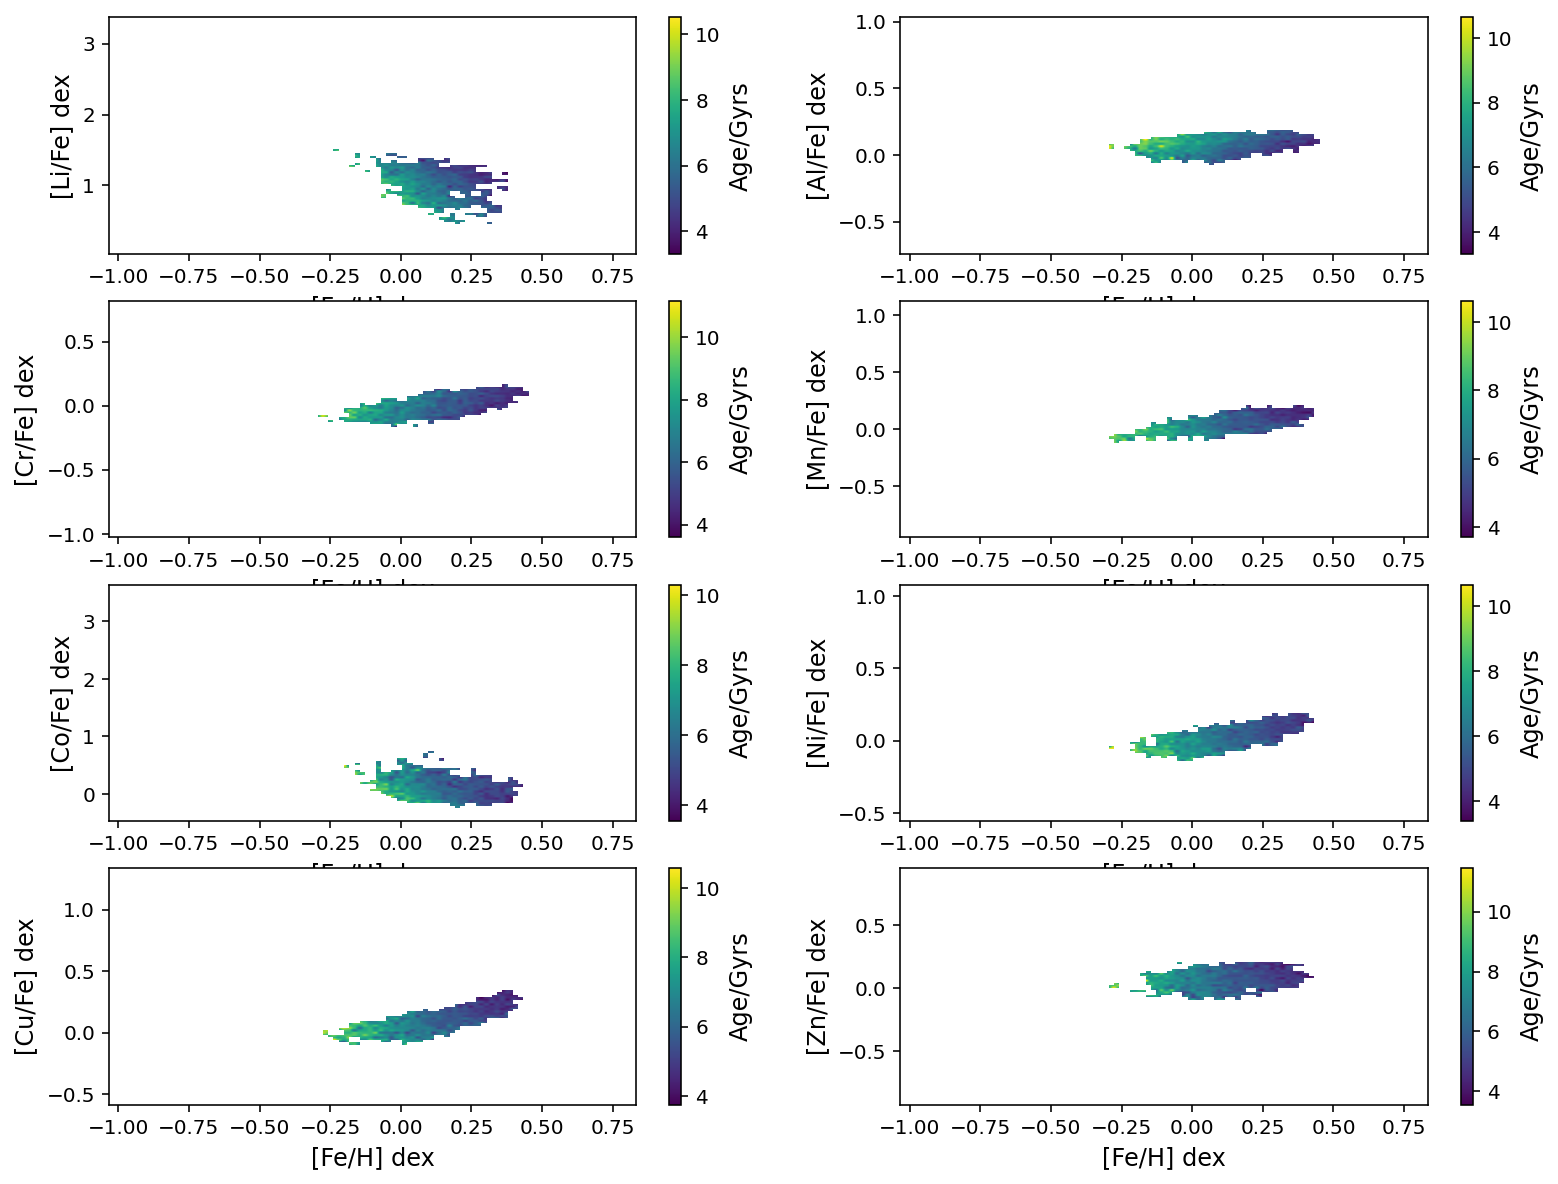

In [18]:
#Plots elements showing upturn at [Fe/H]>0
f, gs = plt.subplots(4,2,figsize=(13,10))
hist2d_new(galah, good, 'fe_h','Li_fe','age_bstep' ,ax = gs[0,0], cax = False, cmap = 'viridis')
hist2d_new(galah, good, 'fe_h','Al_fe', 'age_bstep',ax = gs[0,1], cax = False, cmap = 'viridis')
hist2d_new(galah, good, 'fe_h','Cr_fe', 'age_bstep',ax = gs[1,0], cax = False, cmap = 'viridis')
hist2d_new(galah, good, 'fe_h','Mn_fe', 'age_bstep',ax = gs[1,1], cax = False, cmap = 'viridis')
hist2d_new(galah, good, 'fe_h','Co_fe', 'age_bstep',ax = gs[2,0], cax = False, cmap = 'viridis')
hist2d_new(galah, good, 'fe_h','Ni_fe', 'age_bstep',ax = gs[2,1], cax = False, cmap = 'viridis')
hist2d_new(galah, good, 'fe_h','Cu_fe', 'age_bstep',ax = gs[3,0], cax = False, cmap = 'viridis')
hist2d_new(galah, good, 'fe_h','Zn_fe', 'age_bstep',ax = gs[3,1], cax = False, cmap = 'viridis');

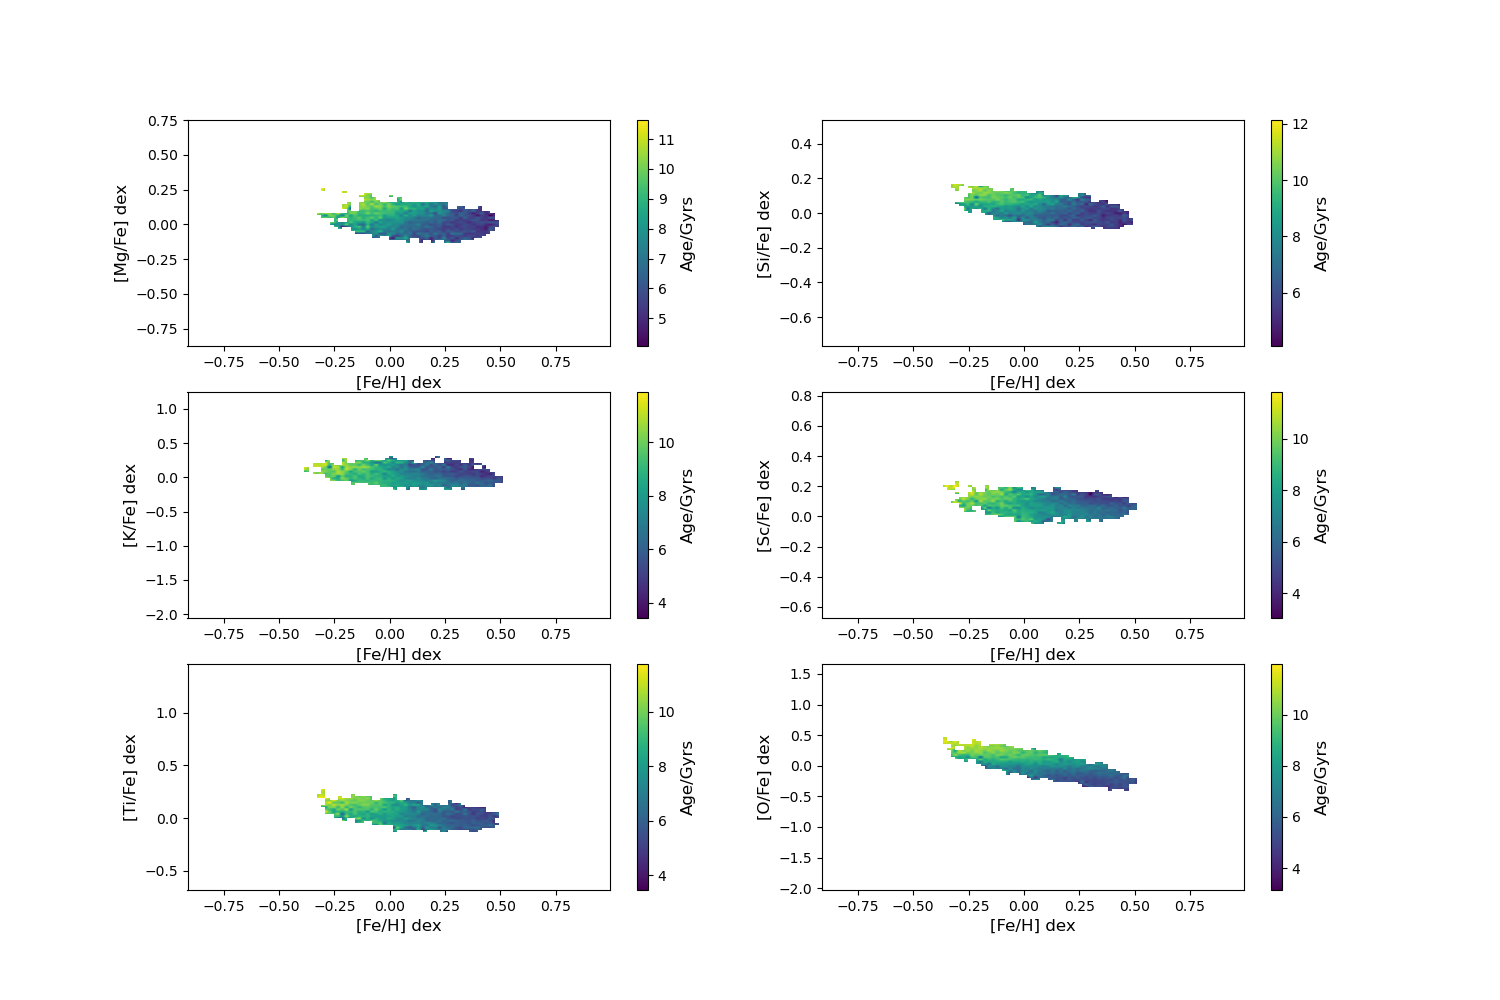

In [6]:
#Plots elements showing plateau and down-turn at [Fe/H]>0
f, gs = plt.subplots(3,2,figsize=(15,10))
hist2d_new(galah, good, 'fe_h','Mg_fe','age_bstep',ax = gs[0,0], cax = False, cmap = 'viridis')
hist2d_new(galah, good, 'fe_h','Si_fe', 'age_bstep',ax = gs[0,1], cax = False, cmap = 'viridis')
hist2d_new(galah, good, 'fe_h','K_fe', 'age_bstep',ax = gs[1,0], cax = False, cmap = 'viridis')
hist2d_new(galah, good, 'fe_h','Sc_fe', 'age_bstep',ax = gs[1,1], cax = False, cmap = 'viridis')
hist2d_new(galah, good, 'fe_h','Ti_fe', 'age_bstep',ax = gs[2,0], cax = False, cmap = 'viridis')
hist2d_new(galah, good, 'fe_h','O_fe', 'age_bstep',ax = gs[2,1], cax = False, cmap = 'viridis');

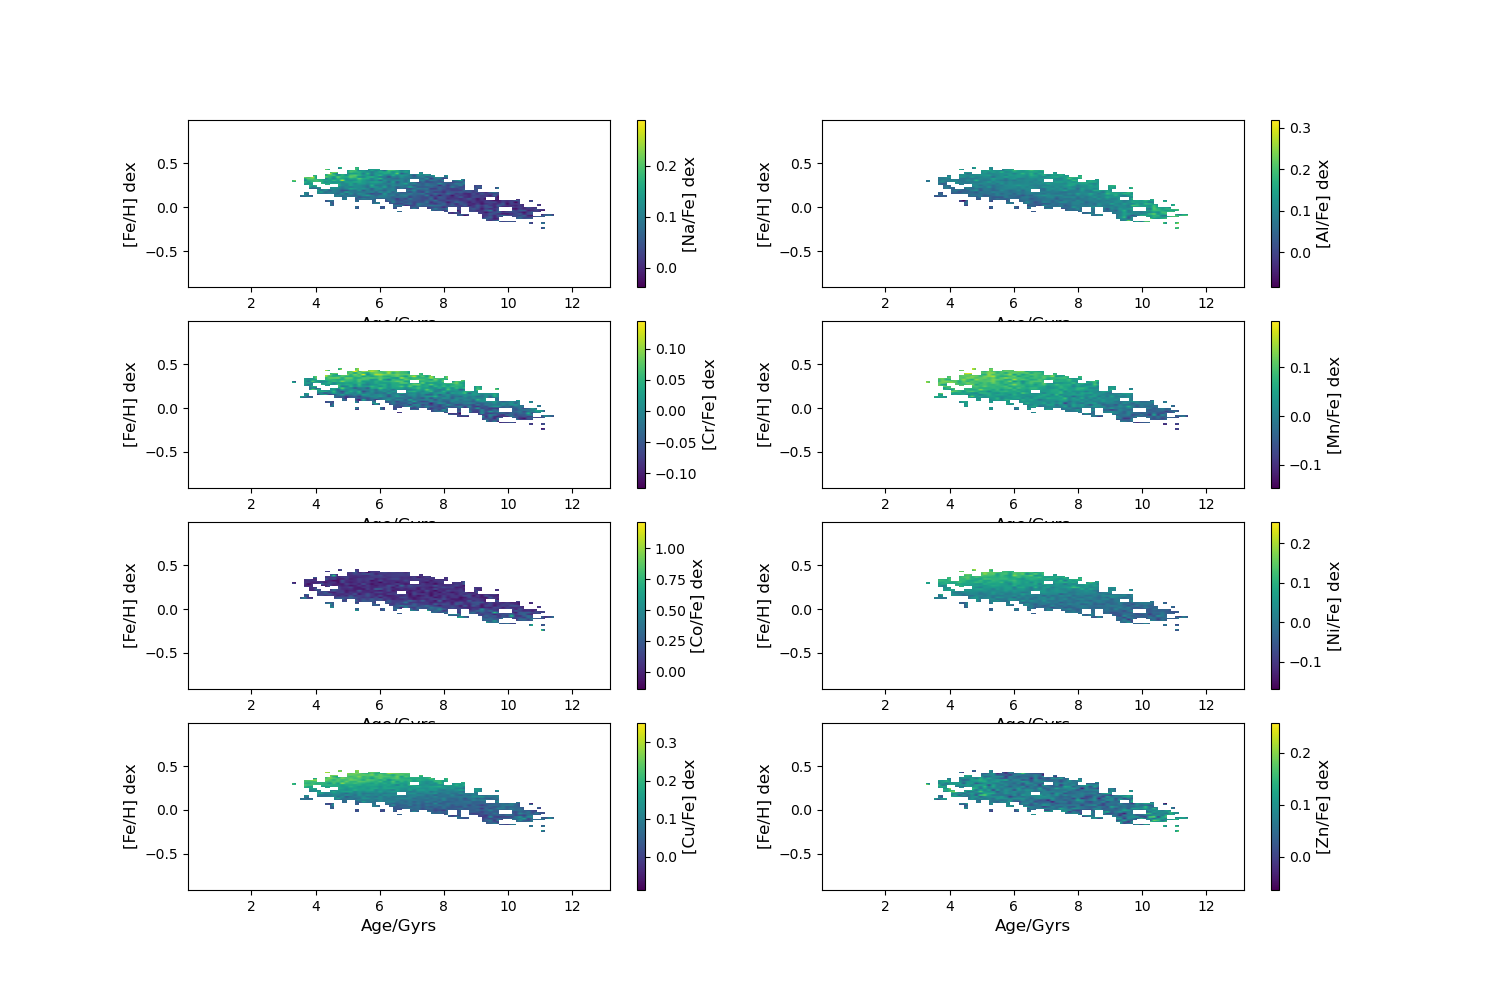

In [7]:
f, gs = plt.subplots(4,2,figsize=(15,10))
hist2d_new(galah, good,'age_bstep', 'fe_h','Na_fe',ax = gs[0,0], cax = False, cmap = 'viridis')
hist2d_new(galah, good,'age_bstep', 'fe_h','Al_fe', ax = gs[0,1], cax = False, cmap = 'viridis')
hist2d_new(galah, good, 'age_bstep','fe_h','Cr_fe',ax = gs[1,0], cax = False, cmap = 'viridis')
hist2d_new(galah, good, 'age_bstep','fe_h','Mn_fe' ,ax = gs[1,1], cax = False, cmap = 'viridis')
hist2d_new(galah, good, 'age_bstep','fe_h','Co_fe' ,ax = gs[2,0], cax = False, cmap = 'viridis')
hist2d_new(galah, good, 'age_bstep','fe_h','Ni_fe' ,ax = gs[2,1], cax = False, cmap = 'viridis')
hist2d_new(galah, good, 'age_bstep','fe_h','Cu_fe', ax = gs[3,0], cax = False, cmap = 'viridis')
hist2d_new(galah, good,  'age_bstep','fe_h','Zn_fe',ax = gs[3,1], cax = False, cmap = 'viridis');

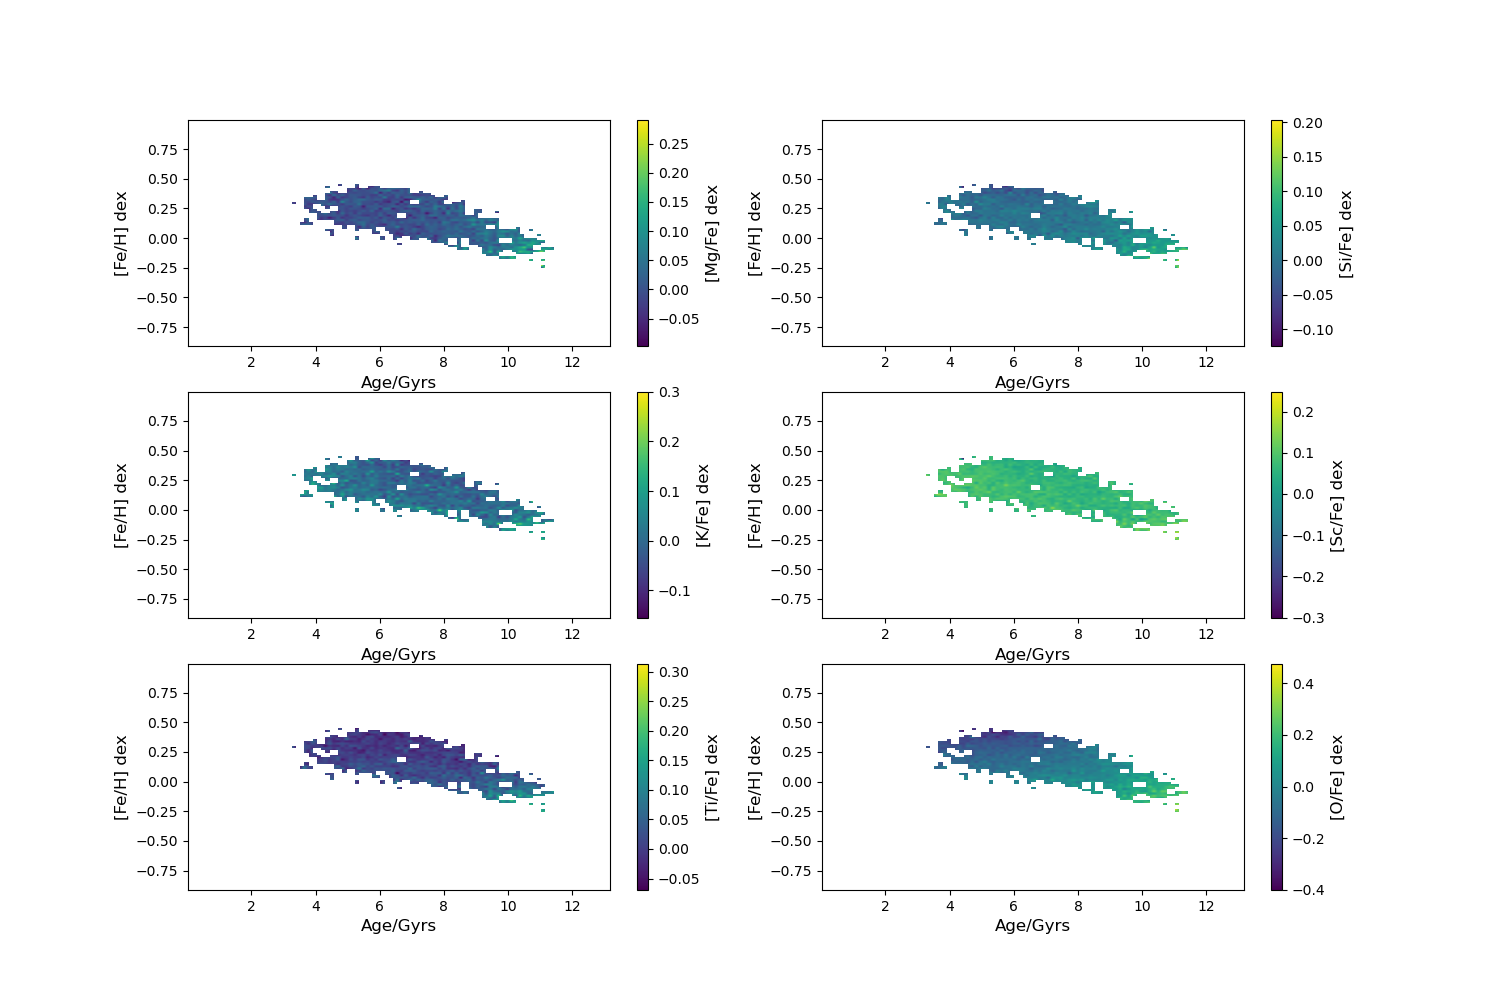

In [16]:
f, gs = plt.subplots(3,2,figsize=(15,10))
hist2d_new(galah, good,'age_bstep', 'fe_h','Mg_fe',ax = gs[0,0], cax = False, cmap = 'viridis')
hist2d_new(galah, good,'age_bstep', 'fe_h','Si_fe', ax = gs[0,1], cax = False, cmap = 'viridis')
hist2d_new(galah, good, 'age_bstep','fe_h','K_fe',ax = gs[1,0], cax = False, cmap = 'viridis')
hist2d_new(galah, good, 'age_bstep','fe_h','Sc_fe' ,ax = gs[1,1], cax = False, cmap = 'viridis')
hist2d_new(galah, good, 'age_bstep','fe_h','Ti_fe' ,ax = gs[2,0], cax = False, cmap = 'viridis')
hist2d_new(galah, good, 'age_bstep','fe_h','O_fe' ,ax = gs[2,1], cax = False, cmap = 'viridis')

[[ 8.20961990e-05 -8.34512492e-06 -3.36322619e-06]
 [-8.34512492e-06  7.89295834e-06 -4.05365099e-07]
 [-3.36322619e-06 -4.05365099e-07  5.02336497e-07]]
[0.0090607  0.00280944 0.00070876]
[ 0.0403291   0.25153698 -0.00133317]
[ 0.0312684   0.24872754 -0.00204193]


C:\Users\z5318089\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


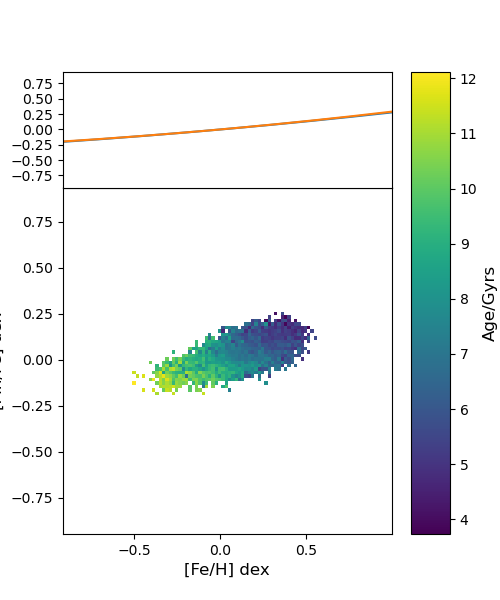

In [7]:
#creates the figure
fig=plt.figure(figsize=(5,6))

# cretes big grid spec for the data
gs=fig.add_gridspec(nrows=4,ncols=7,hspace=0, wspace = 0.5)

# creates axes specifying rows and columns from the grids
ax1=fig.add_subplot(gs[1:,:-1])

# creates axes specifying rows and columns from the grids sharing the axes with ax1
ax2 = fig.add_subplot(gs[0,:-1], sharex = ax1, sharey = ax1)

# creates axes specifying rows and columns from the grids for the color bar
cax = fig.add_subplot(gs[:,-1])

# makes a polynominal fit to the data
poly,cov = np.polyfit(galah['fe_h'][good], galah['Mn_fe'][good], w = 1/galah['e_Mn_fe'][good],deg = 2, cov=True)
print(cov)
sig=np.sqrt(np.diag(cov))
print(sig)

polymax=np.poly1d(poly+sig)
print(poly+sig)
poly = np.poly1d(poly)
x = np.arange(np.amin(galah['fe_h'][good]), np.amax(galah['fe_h'][good]),0.01)

#creates poly plot
ax2.plot(x, poly(x))
ax2.plot(x, polymax(x))



#Displays the coefficients to the fit
print(poly.coef)

#Hides the ticks for ax2- the top plots
ax2.tick_params(axis = 'x', which = 'both', bottom = False, top = False, labelbottom = False)

#creates Hist 
hist2d_new(galah, good, 'fe_h','Mn_fe','age_bstep',ax= ax1, cax = cax, cmap = 'viridis')
plt.show()


Not all values were finite! Continuing with only finite ones
Not all values were finite! Continuing with only finite ones


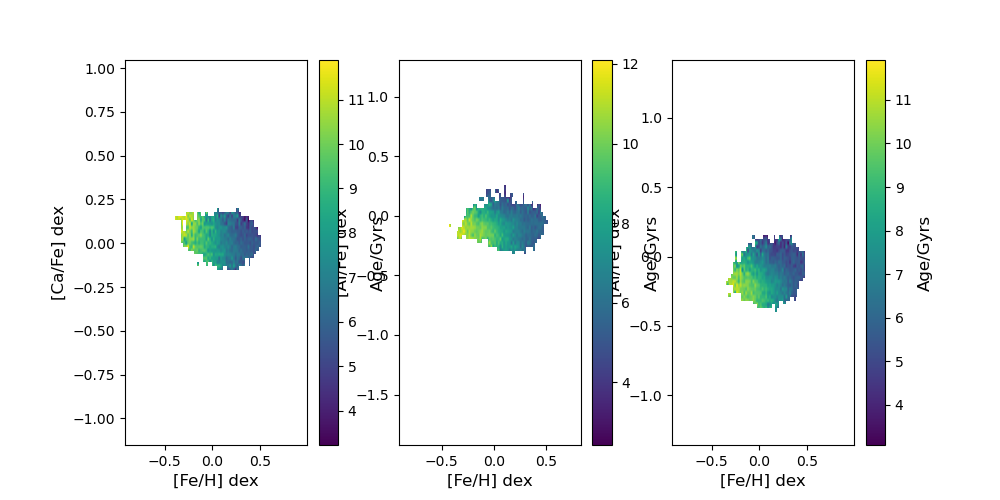

In [11]:
f, gs = plt.subplots(1,3,figsize=(10,5))
hist2d_new(galah, good, 'fe_h','Ca_fe','age_bstep',ax = gs[0], cax = False, cmap = 'viridis')
hist2d_new(galah, good, 'fe_h','Ba_fe', 'age_bstep',ax = gs[1], cax = False, cmap = 'viridis')
hist2d_new(galah, good, 'fe_h','Y_fe', 'age_bstep',ax = gs[2], cax = False, cmap = 'viridis')
#hist2d_new(galah, good, 'fe_h','Mn_fe', 'age_bstep',ax = gs[1,1], cax = False, cmap = 'viridis')


Not all values were finite! Continuing with only finite ones
Not all values were finite! Continuing with only finite ones


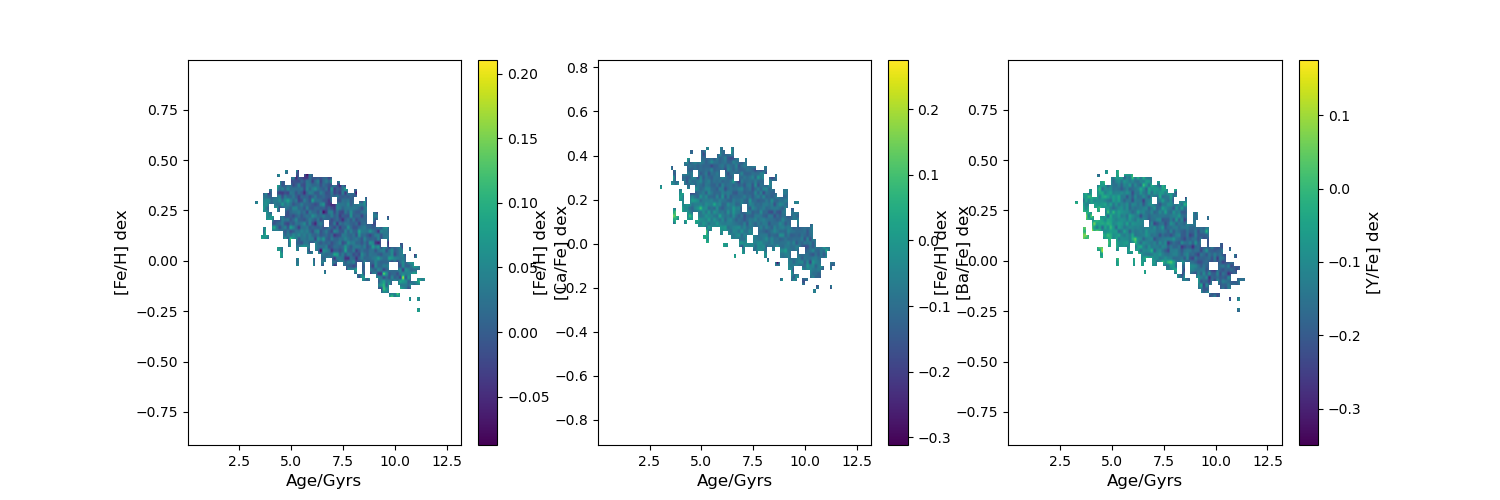

In [14]:
f, gs = plt.subplots(1,3,figsize=(14,5))
hist2d_new(galah, good,'age_bstep', 'fe_h','Ca_fe',ax = gs[0], cax = False, cmap = 'viridis')
hist2d_new(galah, good,'age_bstep', 'fe_h','Ba_fe', ax = gs[1], cax = False, cmap = 'viridis')
hist2d_new(galah, good, 'age_bstep','fe_h','Y_fe',ax = gs[2], cax = False, cmap = 'viridis')